In [1]:
import os
os.chdir(r'5 - TransformerXL')
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.tensorboard import SummaryWriter
from itertools import chain, cycle, groupby
from functools import reduce
from typing import Collection, List
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)
from midi_encoding import *
from einops import rearrange, repeat, pack, unpack, einsum
import faiss
import time
import math

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


In [3]:
!nvidia-smi

Mon Aug 26 16:38:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0  On |                  Off |
| 35%   45C    P0             47W /  450W |    2468MiB /  24564MiB |     40%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
vocab = MusicVocab()
vocab.size

392

In [5]:
class ContiguousBatchSampler(Sampler):
    def __init__(self, dataset): #, start_offset=0):
        self.dataset = dataset
        self.batches = []
        #self.start_offset = start_offset # Allows resuming training from a specific batch
    
    def precompute_indices(self, batch_size):
        
        file_count = len(self.dataset.file_lengths)
        if file_count < batch_size:
            raise ValueError('The number of files must be greater than or equal to the batch size, as files must be spread across a single batch dimension.')
        
        file_idxs = list(range(batch_size))
        file_positions = [0] * batch_size

        while True:
            batch = []
            for batch_idx in range(batch_size):
                
                current_file_idx = file_idxs[batch_idx]
                current_file_position = file_positions[batch_idx]
                current_file_length = self.dataset.file_lengths[current_file_idx]
                
                # Check if the current file is exhausted
                if current_file_position == current_file_length:
                    # Find the next file that hasn't been started
                    files_exhausted = True
                    min_file_index = max(file_idxs) + 1
                    for next_file_idx in range(min_file_index, file_count):
                        if self.dataset.file_lengths[next_file_idx] > 0:
                            current_file_idx = next_file_idx
                            current_file_position = 0
                            file_idxs[batch_idx] = current_file_idx
                            file_positions[batch_idx] = current_file_position
                            files_exhausted = False
                            break
                    
                    if files_exhausted:
                        return

                batch.append([current_file_idx, current_file_position])                
                file_positions[batch_idx] += 1

            self.batches.append(batch)

    def __iter__(self):
        for batch in cycle(self.batches): #[self.start_offset:]:
            yield batch

    def __len__(self):
        return len(self.batches)

In [6]:
class MidiDataset(Dataset):
    def __init__(self, file_names, midi_path, score_path, sample_length):
        self.file_names = file_names
        self.data = None
        self.file_lengths = None
        self.total_samples = 0
        self.sample_length = sample_length
        self.midi_path = midi_path
        self.score_path = score_path

    @torch.no_grad()
    def load_samples(self):
        data = []
        file_lengths = []
        for file_name in self.file_names:

            midi_file_path = Path(self.midi_path, file_name)
            score_file_path = Path(self.score_path, file_name)
            encoded_file_path = Path(self.score_path, f'{file_name}.npy')

            if (encoded_file_path.exists()):
                # print(f'Loading {score_file_path}')
                idx_score = np.load(encoded_file_path, allow_pickle=True)
            else:
                # print(f'Processing {midi_file_path}')
                idx_score = midifile_to_idx_score(midi_file_path, vocab, True)
                if (idx_score is None): # Skip files that could not be processed
                    # print(f'Could not process {midi_file_path}')
                    continue
                np.save(score_file_path, idx_score)

            samples = []
            
            # Split idx_score into blocks of size sample_length, padding the last blocks if necessary
            for i in range(0, len(idx_score), self.sample_length):
                block = idx_score[i:i + self.sample_length]
                if len(block) < self.sample_length:
                    last_tidx = block[-1, 1]
                    pad_tidx = last_tidx + 1
                    padding_count = self.sample_length - len(block)
                    padding = np.stack([[vocab.pad_idx, pad_tidx]] * padding_count)
                    block = np.concatenate([block, padding])

                samples.append(block)

            if len(samples) == 0: # Skip files with no valid samples
                continue
            
            data.append(torch.tensor(np.array(samples), device=device))
            file_lengths.append(len(samples))
        
        self.total_samples = sum(file_lengths)
        self.data = torch.nested.nested_tensor(data, device=device)
        self.file_lengths = torch.tensor(file_lengths, device=device)
    
    def __len__(self):
        return self.total_samples
    
    def __getitem__(self, idx):
        file_idx = idx[0]
        sample_idx = idx[1]
        sample = self.data[file_idx, sample_idx] # = self.data[idx]
        return file_idx, sample

In [7]:
vg_large_path = Path('../data/midi/vg_large')
vg_large_file_names = [f for f in os.listdir(vg_large_path) if os.path.isfile(os.path.join(vg_large_path, f))]

# Ensure files are shuffled directly after assignment.
# If they are shuffled in a different cell, and that cell is run multiple times, the order will change as we are shuffling the already-shuffled list.
random.seed(42)
random.shuffle(vg_large_file_names)

len(vg_large_file_names)

3839

I think we will have to go with splitting on filenames again this time, even though this doesn't equate to the same split in volume of training data (as not all tracks are the same length).

We avoided this with the vanilla transformer by appending all files into one mega-performance and splitting that, but here we need to have files assigned and locked to a given batch dimension.

In [8]:
# I think these would be difficult to change after the model training has begun as the batch idxs and memory dimensions would already be established.
# We might be able to start a 'second phase' of training by changing these values and clearing the memories.
batch_size = 32
sample_length = 256

midi_path = Path('../data/midi/vg_large')
score_path = Path(f'../data/numpy/vg_large/all')

n1 = int(0.8 * len(vg_large_file_names))
n2 = int(0.9 * len(vg_large_file_names))
train_filenames = vg_large_file_names[:n1]
valid_filenames = vg_large_file_names[n1:n2]
test_filenames = vg_large_file_names[n2:]

print(f'File counts - train: {len(train_filenames)}, valid: {len(valid_filenames)}, test: {len(test_filenames)}')

train_dataset = MidiDataset(train_filenames, midi_path, score_path, sample_length)
valid_dataset = MidiDataset(valid_filenames, midi_path, score_path, sample_length)
test_dataset = MidiDataset(test_filenames, midi_path, score_path, sample_length)

print(f'Loading train samples')
train_dataset.load_samples()

print(f'Loading valid samples')
valid_dataset.load_samples()

print(f'Loading test samples')
test_dataset.load_samples()

File counts - train: 3071, valid: 384, test: 384
Loading train samples


/opt/conda/lib/python3.10/site-packages/torch/nested/__init__.py:166: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


Loading valid samples
Loading test samples


In [9]:
train_sampler = ContiguousBatchSampler(train_dataset)
valid_sampler = ContiguousBatchSampler(valid_dataset)
test_sampler = ContiguousBatchSampler(test_dataset)

print(f'Precomputing indices')
train_sampler.precompute_indices(batch_size)
valid_sampler.precompute_indices(batch_size)
test_sampler.precompute_indices(batch_size)

train_dataloader = iter(DataLoader(train_dataset, batch_sampler=train_sampler))
valid_dataloader = iter(DataLoader(valid_dataset, batch_sampler=valid_sampler))
test_dataloader = iter(DataLoader(test_dataset, batch_sampler=test_sampler))

Precomputing indices


In [10]:
class KNN():

    @torch.no_grad()
    def __init__(self, dim, max_memories, db_filepath):
        self.dim = dim
        self.max_memories = max_memories
        self.shape = (max_memories, 2, dim)
        self.db_offset = 0
        self.db = torch.zeros(self.shape, dtype = torch.float32, device=device) # np.memmap(db_filepath, mode = 'w+', dtype = np.float32, shape = self.shape)
        self.index = faiss.IndexIDMap(faiss.IndexFlatL2(dim))

    @torch.no_grad()
    def add_to_db(self, new_data):
        new_data_len = new_data.shape[0] # (t)

        if new_data_len > self.max_memories:
            raise ValueError('Batch size exceeds memory limit.')

        # Circular buffer
        # ids = (np.arange(new_data_len) + self.db_offset) % self.max_memories
        ids = (torch.arange(new_data_len) + self.db_offset) % self.max_memories

        self.db[ids] = new_data#.detach().cpu().numpy()
        self.db_offset += new_data_len
        # Write to file
        # self.db.flush()

        return ids

    @torch.no_grad()
    def search_and_retrieve(self, query, k):

        # The tooltip says the args are (n, x, k) but that's the CPP api, it's actually (x, k) in Python (n is the first dim of x anyway so can be inferred).
        distances, indices = self.index.search(query, k)
        
        kvs = self.db[indices]
        return kvs

    @torch.no_grad()
    def add(self, new_data):
        # new_data = (t, 2, c)

        # Add to db
        new_ids = self.add_to_db(new_data)
        new_ids = new_ids.detach().cpu().numpy()

        # Only keys are used in knn index
        keys, vals = new_data.unbind(dim=-2)

        # Add (t, c) tensors to index
        keys = keys.detach().cpu().numpy()
        keys = np.ascontiguousarray(keys)

        self.index.remove_ids(new_ids)
        self.index.add_with_ids(keys, new_ids)

    @torch.no_grad()
    def search(self, query, k):

        T, C = query.shape
        
        # If we have enough memories, search and retrieve, otherwise return zeros
        if self.index.ntotal >= k:
            kvs = self.search_and_retrieve(np.ascontiguousarray(query.detach().cpu().numpy()), k)
            # kvs = torch.tensor(kvs, device=device)
        else:
            kvs = torch.zeros((T, k, 2, C), device=device)

        return kvs

    @torch.no_grad()
    def clear(self):
        self.index.reset()
        # self.db[:] = 0
        self.db = torch.zeros(self.shape, dtype = torch.float32, device=device)
        self.db_offset = 0
        # print('Flushing DB')
        # self.db.flush() # Is this necessary?
        # print('Db Flushed')


In [11]:
class XLRelativePosition(torch.nn.Module):
  def __init__(
      self,
      n_buckets,
      max_distance,
      n_head,
      scaling_factor):
    
    super().__init__()
    self.scale = scaling_factor
    self.num_buckets = n_buckets
    self.max_distance = max_distance
    self.relative_attention_embedding = torch.nn.Embedding(n_buckets, n_head)

  def relative_position_bucket(self, relative_position_matrix):
    inv_rel_pos = -relative_position_matrix
    masked_rel_pos = torch.max(inv_rel_pos, torch.zeros_like(inv_rel_pos, device=device))

    max_exact = self.num_buckets // 2

    is_small = masked_rel_pos < max_exact
    val_if_large = max_exact + (torch.log(masked_rel_pos.float() / max_exact) / math.log(self.max_distance / max_exact) * (self.num_buckets - max_exact)).long()

    # Clip the values to the number of buckets - 1
    val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, self.num_buckets - 1, device=device))

    return torch.where(is_small, masked_rel_pos, val_if_large)

  def forward(self, block_size):
    block_pos = torch.arange(block_size, dtype=torch.long, device=device)
    context_pos = torch.arange(-block_size, block_size, dtype=torch.long, device=device) # XL memory, context is twice block size, and current position starts in the middle.
    block_rel_pos = rearrange(block_pos, 'i -> i 1')
    context_rel_pos = rearrange(context_pos, 'j -> 1 j')
    rel_pos = context_rel_pos - block_rel_pos

    position_bucket_indices = self.relative_position_bucket(rel_pos)

    rp_values = self.relative_attention_embedding(position_bucket_indices)

    rp_values = rearrange(rp_values, 'i j h -> () h i j')
    return rp_values * self.scale

In [12]:
class XLAttention(torch.nn.Module):

    def __init__(self, n_embed, n_head, dropout):
        super().__init__()
        self.n_embed = n_embed
        self.n_head = n_head
        self.head_size = n_embed // n_head
        head_total_size = n_head * self.head_size
        self.key = torch.nn.Linear(n_embed, head_total_size, bias=False)
        self.query = torch.nn.Linear(n_embed, head_total_size, bias=False)
        self.value = torch.nn.Linear(n_embed, head_total_size, bias=False)
        self.project = torch.nn.Linear(head_total_size, n_embed)
        self.dropout = torch.nn.Dropout(dropout)    

    def forward(self, relative_positions, x, xl_memory = None):

        B, T, C = x.shape

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        # Chris's implementation does `queries = queries * (self.head_size ** -0.5)` here but I don't think it is correct.

        if xl_memory is not None:
            k_xl, v_xl = xl_memory.unbind(dim = -2) # assume stacked
            k = torch.cat((k_xl, k), dim = -2) # prepend XL memory
            v = torch.cat((v_xl, v), dim = -2) # prepend XL memory

        ### LOCAL ATTENTION

        # Split heads
        q = rearrange(q, 'b t (h d) -> b h t d', h = self.n_head)
        k = rearrange(k, 'b t (h d) -> b h t d', h = self.n_head)
        v = rearrange(v, 'b t (h d) -> b h t d', h = self.n_head)

        w = einsum(q, k, 'b h i d, b h j d -> b h i j')
        i, j = w.shape[-2:]

        # Add relative positional encoding and scale
        w = w + relative_positions[..., -i:, -j:]
        w = w * (self.head_size ** -0.5)
        
        mask = torch.logical_not(torch.tril(torch.ones((i,j), dtype = torch.bool, device=device))) # Can't cache this as its shape depends on whether we have XL memory or not.
        w = w.masked_fill(mask, float('-inf'))

        self.dropout(w)
        w = F.softmax(w, dim=-1)

        weighted_values = w@v # b h t d
        # Concat heads
        weighted_values = rearrange(weighted_values, 'b h t d -> b t (h d)')
        
        out = self.project(weighted_values)

        # new XL memories

        # Concatenate key and value heads
        k = rearrange(k, 'b h t d -> b t (h d)', h = self.n_head)
        v = rearrange(v, 'b h t d -> b t (h d)', h = self.n_head)
        current_kv = torch.stack((k, v), dim=-2) # b t 2 (h d)

        if xl_memory is None:
            new_xl_memory = current_kv
        else:
            new_xl_memory = current_kv[:, -T:]

        return self.dropout(out), new_xl_memory

In [13]:
class KNN_XLAttention(torch.nn.Module):

    def __init__(self, dbFilePath, batch_size, k, n_embed, n_head, dropout):
        super().__init__()
        self.n_embed = n_embed
        self.k = k
        self.n_head = n_head
        head_size = n_embed // n_head
        self.scale_factor = head_size ** -0.5
        self.key = torch.nn.Linear(n_embed, n_embed, bias=False)
        self.query = torch.nn.Linear(n_embed, n_embed, bias=False)
        self.value = torch.nn.Linear(n_embed, n_embed, bias=False)
        self.project = torch.nn.Linear(n_embed, n_embed)
        self.dropout = torch.nn.Dropout(dropout)

        # Memory per batch dim. 8192 at 256 per sequence is 32 sequences per batch dim.
        self.knn = {i: KNN(n_embed, 4096, Path(f'{dbFilePath}/batch_dim-{i}.db')) for i in range(batch_size)} # KNN memory will get or create the files, so we just need to be consistent with the file names.
        self.current_file_idxs = None

        self.gate_bias = torch.nn.Parameter(torch.randn(self.n_head, 1, 1))
    

    def forward(self, batch_file_idxs, relative_positions, x, xl_memory = None):

        # Clear batch dim's knn memory if file changes
        if self.current_file_idxs != None:
            for i in range(len(self.current_file_idxs)):
                if self.current_file_idxs[i] != batch_file_idxs[i]:
                    self.knn[i].clear()

        self.current_file_idxs = batch_file_idxs

        B, T, C = x.shape

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        # This helps to mitigate drift in the embeddings which can cause the historical keys to become less aligned to the current queries.
        q = F.normalize(q, dim=-1)
        k = F.normalize(k, dim=-1)

        if xl_memory is not None:
            k_xl, v_xl = xl_memory.unbind(dim = -2) # assume stacked
            k = torch.cat((k_xl, k), dim = -2) # prepend XL memory
            v = torch.cat((v_xl, v), dim = -2) # prepend XL memory

        ### LOCAL ATTENTION

        # Split heads
        q = rearrange(q, 'b t (h d) -> b h t d', h = self.n_head)
        k = rearrange(k, 'b t (h d) -> b h t d', h = self.n_head)
        v = rearrange(v, 'b t (h d) -> b h t d', h = self.n_head)

        w = einsum(q, k, 'b h i d, b h j d -> b h i j')
        i, j = w.shape[-2:]
        
        # Add relative positional encoding and scale

        w = w + relative_positions[..., -i:, -j:]
        w = w * self.scale_factor

        mask = torch.logical_not(torch.tril(torch.ones((i,j), dtype = torch.bool, device=device))) # Can't cache this as its shape depends on whether we have XL memory or not.
        w = w.masked_fill(mask, float('-inf'))
        
        self.dropout(w)
        w = F.softmax(w, dim=-1)

        weighted_values = w@v # b h t d

        ### KNN ATTENTION
        knn_mask = torch.tensor([self.knn[i].index.ntotal > 0 for i in range(B)], dtype=torch.bool, device=device)

        # Only do knn if there are at least some memories
        if knn_mask.any():

            # t1 = time.time()
            # print ("Begin KNN operations")

            # Convert queries to search form
            q = rearrange(q, 'b h t d -> b t (h d)')

            # KNN returns zeroes if it doesn't have data.
            mem_kv = torch.stack([self.knn[i].search(q[i], k = self.k) for i in range(B)], dim = 0) # b, t, k, 2, c
            
            mem_k, mem_v = mem_kv.unbind(dim = -2)
            mem_k = rearrange(mem_k, 'b t k (h d) -> b h t k d', h=self.n_head)
            mem_v = rearrange(mem_v, 'b t k (h d) -> b h t k d', h=self.n_head)

            # Convert queries to attention form
            q = rearrange(q, 'b t (h d) -> b h t d', h = self.n_head)

            # Sum over d for each combination of batch, head, time and top k to get qk affinities, and hence weights for each k. resulting in a tensor of shape (b, h, t, k).
            mem_w = einsum(q, mem_k, 'b h t d, b h t k d -> b h t k')
            mem_w = mem_w * self.scale_factor

            self.dropout(mem_w)
            mem_w = F.softmax(mem_w, dim=-1)

            # Weighted sum over the top k dimension for each combination of b, h, and t, resulting in a tensor of shape (b, h, t, d). Equivalent to doing w@v for each k and summing.
            mem_weighted_values = einsum(mem_w, mem_v, 'b h t k, b h t k d -> b h t d')

            ## Combined attention
            
            # Assume every memory has content. Empty memories will be masked out below.
            combined_weighted_values = mem_weighted_values * self.gate_bias + weighted_values * (1 - self.gate_bias)

            # Mask out combined weighted values where knn memory *is* empty and non-combined values where it *is not* empty, then merge them.
            combined_weighted_values = combined_weighted_values * knn_mask.view(B, 1, 1, 1) + weighted_values * (~knn_mask).view(B, 1, 1, 1)

            # Concat heads
            combined_weighted_values = rearrange(combined_weighted_values, 'b h t d -> b t (h d)')
            out = self.project(combined_weighted_values)

            # t2 = time.time()
            # print ("End KNN operations, time taken:", t2-t1)

        else:
            # Concat heads
            weighted_values = rearrange(weighted_values, 'b h t d -> b t (h d)')
            out = self.project(weighted_values)


        # New XL memories

        # Concatenate key and value heads
        k = rearrange(k, 'b h t d -> b t (h d)', h = self.n_head)
        v = rearrange(v, 'b h t d -> b t (h d)', h = self.n_head)
        current_kv = torch.stack((k, v), dim=-2) # b t 2 c

        if xl_memory is None:
            new_xl_memory = current_kv
        else:
            new_xl_memory = current_kv[:, -T:]

        for i in range(B):
            self.knn[i].add(new_xl_memory[i])

        return self.dropout(out), new_xl_memory

In [14]:
class FeedForward(torch.nn.Module):

    def __init__(self, n_embed, dropout):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_embed, 4 * n_embed), # 4x is a common expansion factor
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(4 * n_embed, n_embed) # Project back to the residual stream
        )

    def forward(self, x):
        return self.net(x)
    
class Block(torch.nn.Module):

    def __init__(self, n_embed, n_head, dropout):
        super().__init__()
        self.attention = XLAttention(
                            n_embed,
                            n_head,
                            dropout)
        self.ff = FeedForward(n_embed, dropout)
        self.layer_norm1 = torch.nn.LayerNorm(n_embed)
        self.layer_norm2 = torch.nn.LayerNorm(n_embed)

    def forward(self, rel_pos, x, xl_memories):
        # Residual connections
        attn_out, new_xl_memories = self.attention(rel_pos, self.layer_norm1(x), xl_memories)
        x = x + attn_out
        x = x + self.ff(self.layer_norm2(x))
        return x, new_xl_memories
    
class KNNBlock(torch.nn.Module):

    def __init__(self, dbFilePath, n_embed, n_head, top_k, dropout):
        super().__init__()
        self.attention = KNN_XLAttention(
                            dbFilePath,
                            batch_size,
                            top_k,
                            n_embed,
                            n_head,
                            dropout)
        self.ff = FeedForward(n_embed, dropout)
        self.layer_norm1 = torch.nn.LayerNorm(n_embed)
        self.layer_norm2 = torch.nn.LayerNorm(n_embed)

    def forward(self, batch_file_idxs, relative_positions, x, xl_memory = None):
        # Residual connections
        attn_out, new_xl_memories = self.attention(batch_file_idxs, relative_positions, self.layer_norm1(x), xl_memory)
        x = x + attn_out
        x = x + self.ff(self.layer_norm2(x))
        return x, new_xl_memories

In [29]:
class DecoderTransformer_KNN_XL(torch.nn.Module):

    def __init__(
            self,
            dbFilePath,
            vocab_size,
            batch_size, # required so we can init a memory per batch dim
            sample_length,
            n_embed = 384, # /6 heads = 64 per head
            n_head = 6, 
            n_layer = 6, 
            max_bar_position = 1024,
            top_k = 5,
            dropout = 0.2,
            n_rel_pos_buckets = 32,
            rel_pos_max_distance = 128):
        
        super().__init__()
        head_size = n_embed // n_head
        scaling_factor = head_size ** 0.5
        self.sample_length = sample_length
        self.n_layer = n_layer
        self.batch_size = batch_size
        self.max_bar_position = max_bar_position
        self.token_embedding = torch.nn.Embedding(vocab_size, n_embed)
        self.rel_pos = XLRelativePosition(n_buckets = n_rel_pos_buckets, max_distance = rel_pos_max_distance, n_head = n_head, scaling_factor = scaling_factor)
        self.rel_pos_knn = XLRelativePosition(n_buckets = n_rel_pos_buckets, max_distance = rel_pos_max_distance, n_head = n_head, scaling_factor = scaling_factor)
        self.beat_embedding = torch.nn.Embedding(SAMPLES_PER_BAR, n_embed)
        self.bar_embedding = torch.nn.Embedding(max_bar_position, n_embed)
        
        self.blocks = torch.nn.ModuleList([])
        for i in range(n_layer):

            if self.isKNNLayer(i):
                self.blocks.append(KNNBlock(dbFilePath, n_embed, n_head, top_k, dropout))
            else:
                self.blocks.append(Block(n_embed, n_head, dropout))

            
        self.layer_norm = torch.nn.LayerNorm(n_embed)
        self.lm_head = torch.nn.Linear(n_embed, vocab_size)

    def isKNNLayer(self, i):
        return False #i == self.n_layer - 2
    
    # Bit of a hack
    def clear_knn_memory(self):
        # knn = self.blocks[-2].attention.knn
        # for i in range (len(knn)):
        #     knn[i].clear()
        return

    def forward(self, batch_file_idxs, x, xl_memories=None, targets=None):

        B, T, C = x.shape

        # Could split these out in one go using the unbind function
        token_idx = x[:, :, 0] # (B,T)
        time_idx = x[:, :, 1] # (B,T)

        sample_idx = time_idx % SAMPLES_PER_BAR # (B,T)
        bar_idx = (time_idx // SAMPLES_PER_BAR) % self.max_bar_position # (B,T)

        if xl_memories is None:
            xl_memories = (None,) * self.n_layer

        rel_pos = self.rel_pos(T)
        rel_pos_knn = self.rel_pos_knn(T)

        token_embed = self.token_embedding(token_idx) # (B,T,Embed)
        bar_embed = self.bar_embedding(bar_idx) # (B,T,Embed)
        sample_embed = self.beat_embedding(sample_idx) # (B,T,Embed)

        x = token_embed + bar_embed + sample_embed

        # Store the XL memories for each pass
        new_xl_memories = []

        for i, block in enumerate(self.blocks):
            if self.isKNNLayer(i):
                x, xl_mem = block(batch_file_idxs, rel_pos_knn, x, xl_memories[i])
            else:
                x, xl_mem = block(rel_pos, x, xl_memories[i])

            new_xl_memories.append(xl_mem.detach())

        x = self.layer_norm(x)

        # TODO: Convert this section to use einops rearrange
        if targets is None:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None
        else:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            B, T, C = logits.shape
            logits = logits.reshape(B*T, C) # Flatten all the batches
            targets = targets.reshape(B*T)
            loss = F.cross_entropy(logits, targets)

        # if len(new_xl_memories) > 0: # Can these ever be empty?
        return logits, loss, new_xl_memories
        # else:
        #     return logits, loss

    @torch.no_grad()
    def generate(self, x, max_new_tokens=1024, temperature=1.0):
        self.eval()
        
        B, T, C = x.size()

        # We will just have one 'file' per dimension we are generating so that the knn memory is created and persists for the whole generation.
        file_idxs = torch.arange(B, device=device)
        
        xl_memories = None
        self.clear_knn_memory()

        # print(f'idx: {idx.size()}')

        dur_start, _ = vocab.duration_range
        
        for _ in range(max_new_tokens):

            # Get the second to last note index if it exists, otherwise return pad idx
            if x.size(1) > 1:
                second_to_last_nidx = x[:, -2, 0].unsqueeze(0) # (B, 1)
            else:
                second_to_last_nidx = torch.stack([torch.tensor([vocab.pad_idx], device=device) for _ in range(B)], dim=0)

            # print(f'second_to_last_nidx: {second_to_last_nidx.size()}')
            
            # Could probably use unbind here
            last_nidx = x[:, -1, 0] # (B, 1)
            # print(f'last_nidx: {last_nidx.size()}')
            last_tidx = x[:, -1, 1] # (B, 1)
            # print(f'last_tidx: {last_tidx.size()}')

            # If two tokens ago was a separator, the last token was a time-incrementing duration
            duration_mask = second_to_last_nidx == vocab.sep_idx # (B, 1)

            # Offset the duration idx to get the actual duration, and zero out if the previous token was not a separator
            t_inc = (last_nidx - dur_start) * duration_mask
            # print(f't_inc: {t_inc.size()}')

            # Increment the time index by the duration
            tidx_next = last_tidx + t_inc # (B, 1)
            # print(f'tidx: {tidx_next.size()}')

            # if the sequence context is growing too long we must crop it at block_size
            x_cropped = x if x.size(1) <= self.sample_length else x[:, -self.sample_length:]

            # forward the model to get the logits for the index in the sequence
            logits, _, xl_memories = self(file_idxs, x_cropped, xl_memories)

            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature

            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)

            # sample from the distribution
            nidx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # print(f'nidx: {nidx_next.size()}')

            # Concat with the time index
            idx_next = torch.cat((nidx_next, tidx_next), dim=1).unsqueeze(0) # (B, C)
            # print(f'idx_next: {idx_next.size()}')

            # append sampled index to the running sequence and continue
            x = torch.cat((x, idx_next), dim=1) # (B, T+1, C)

        self.train()
        return x

In [16]:
model = DecoderTransformer_KNN_XL(dbFilePath=Path('../data/numpy/knn-demo'), vocab_size=vocab.size, batch_size=batch_size, sample_length=sample_length)

print(sum(p.numel() for p in model.parameters()))

11347976


In [17]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
token_embedding.weight 	 torch.Size([392, 384])
rel_pos.relative_attention_embedding.weight 	 torch.Size([32, 6])
rel_pos_knn.relative_attention_embedding.weight 	 torch.Size([32, 6])
beat_embedding.weight 	 torch.Size([32, 384])
bar_embedding.weight 	 torch.Size([1024, 384])
blocks.0.attention.key.weight 	 torch.Size([384, 384])
blocks.0.attention.query.weight 	 torch.Size([384, 384])
blocks.0.attention.value.weight 	 torch.Size([384, 384])
blocks.0.attention.project.weight 	 torch.Size([384, 384])
blocks.0.attention.project.bias 	 torch.Size([384])
blocks.0.ff.net.0.weight 	 torch.Size([1536, 384])
blocks.0.ff.net.0.bias 	 torch.Size([1536])
blocks.0.ff.net.3.weight 	 torch.Size([384, 1536])
blocks.0.ff.net.3.bias 	 torch.Size([384])
blocks.0.layer_norm1.weight 	 torch.Size([384])
blocks.0.layer_norm1.bias 	 torch.Size([384])
blocks.0.layer_norm2.weight 	 torch.Size([384])
blocks.0.layer_norm2.bias 	 torch.Size([384])
blocks.1.attention.key.weight 	 torch.Size([38

In [18]:
learning_rate = 1e-3
weight_decay = 1e-5

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [19]:
eval_iters = 100

@torch.no_grad()
def estimate_loss(dataloader):
    model.eval()
        
    xl_memories = None
    model.clear_knn_memory()
    losses = torch.zeros(eval_iters)

    for k in range(eval_iters):
        file_idxs, batch = next(dataloader)
        X, Y = batch[:, :-1], batch[:, 1:, 0] # drop absolute position from Y
        _, loss, xl_memories = model(file_idxs, X, xl_memories, Y)
        losses[k] = loss.item()

    model.train()
    
    return losses.mean()

In [20]:
# model_name = 'midi_transformer_knn_xl'
model_name = 'midi_transformer_xl'
model_load_path = Path(f'../data/model/{model_name}.dat')
model_save_path = Path(f'../data/model/{model_name}.dat')
log_dir = Path(f'../tensorboard/{model_name}')
tensorboard_writer = SummaryWriter(log_dir)

average_log_losses = {  
    "train" : [],
    "val" : []
}

def save_checkpoint(iter):
    train_loss = estimate_loss(train_dataloader)
    val_loss = estimate_loss(valid_dataloader)
    tensorboard_writer.add_scalar('Loss/train', train_loss, iter)
    tensorboard_writer.add_scalar('Loss/val', val_loss, iter)
    train_log_loss = train_loss.log10().item()
    val_log_loss = val_loss.log10().item()
    average_log_losses['train'].append(train_log_loss)
    average_log_losses['val'].append(val_log_loss)
    print(f'Iteration {iter}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save({
        'iter': iter,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': average_log_losses,
    }, model_save_path)

In [21]:
eval_interval = 200
iterations = 20000
start_iter = 0

if model_load_path.exists():
    checkpoint = torch.load(model_load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    average_log_losses = checkpoint['losses']
    iter = checkpoint['iter']
    start_iter = iter + 1
    print(f"Loaded model from iteration {iter}")

In [22]:
# import torch.profiler

model.train()

remaining_iters = iterations - start_iter
if remaining_iters != -1:

    # Start with no memory, from the first batch.
    # Could load memories and offset batch index if we wanted to resume training with the same memories.

    print(f"Training for {remaining_iters} iterations")
    
    xl_memories = None
    model.clear_knn_memory()

    # # Initialize the profiler
    # with torch.profiler.profile(
    #     activities=[
    #         torch.profiler.ProfilerActivity.CPU,
    #         torch.profiler.ProfilerActivity.CUDA,
    #     ],
    #     schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    #     on_trace_ready=torch.profiler.tensorboard_trace_handler(log_dir),
    #     record_shapes=True,
    #     profile_memory=True,
    #     with_stack=True
    # ) as prof:
    for iter in range(remaining_iters):

        offset_iter = iter + start_iter

        if offset_iter % eval_interval == 0:
            save_checkpoint(offset_iter)
            xl_memories = None

        # Configure minibatch
        file_idxs, batch = next(train_dataloader)
        
        X, Y = batch[:, :-1], batch[:, 1:, 0]

        # Forward pass
        logits, loss, xl_memories = model(file_idxs, X, xl_memories, Y)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # prof.step()

    save_checkpoint(iterations)

    # Print profiler results
    # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

Training for 20000 iterations
Iteration 0, Train Loss: 6.0840, Val Loss: 6.0905
Iteration 200, Train Loss: 2.1960, Val Loss: 2.2235
Iteration 400, Train Loss: 2.2161, Val Loss: 2.2079
Iteration 600, Train Loss: 2.2079, Val Loss: 2.2323
Iteration 800, Train Loss: 2.1543, Val Loss: 2.1910
Iteration 1000, Train Loss: 2.1890, Val Loss: 2.2197
Iteration 1200, Train Loss: 2.1630, Val Loss: 2.2023
Iteration 1400, Train Loss: 2.1815, Val Loss: 2.2011
Iteration 1600, Train Loss: 2.1574, Val Loss: 2.1925
Iteration 1800, Train Loss: 2.1427, Val Loss: 2.1849
Iteration 2000, Train Loss: 2.1857, Val Loss: 2.1975
Iteration 2200, Train Loss: 2.1508, Val Loss: 2.1898
Iteration 2400, Train Loss: 2.1637, Val Loss: 2.1906
Iteration 2600, Train Loss: 2.1893, Val Loss: 2.1794
Iteration 2800, Train Loss: 2.1219, Val Loss: 2.1801
Iteration 3000, Train Loss: 2.1487, Val Loss: 2.1780
Iteration 3200, Train Loss: 2.1726, Val Loss: 2.1825
Iteration 3400, Train Loss: 2.1125, Val Loss: 2.1630
Iteration 3600, Train L

In [23]:
torch.cuda.empty_cache() 

In [24]:
print('Final training loss:', 10 ** average_log_losses['train'][-1])

Final training loss: 2.0711939094620653


In [25]:
print('Final validation loss:', 10 ** average_log_losses['val'][-1])

Final validation loss: 2.084283794972613


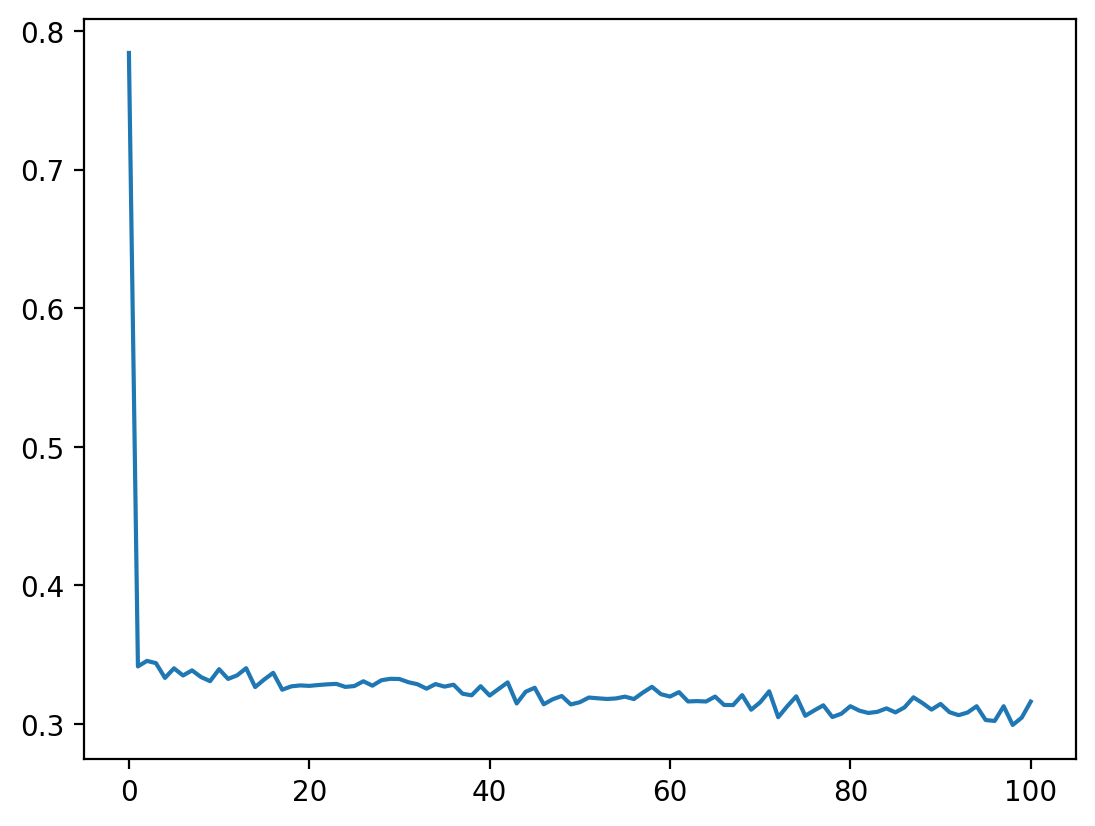

In [26]:
plt.plot(average_log_losses['train'])

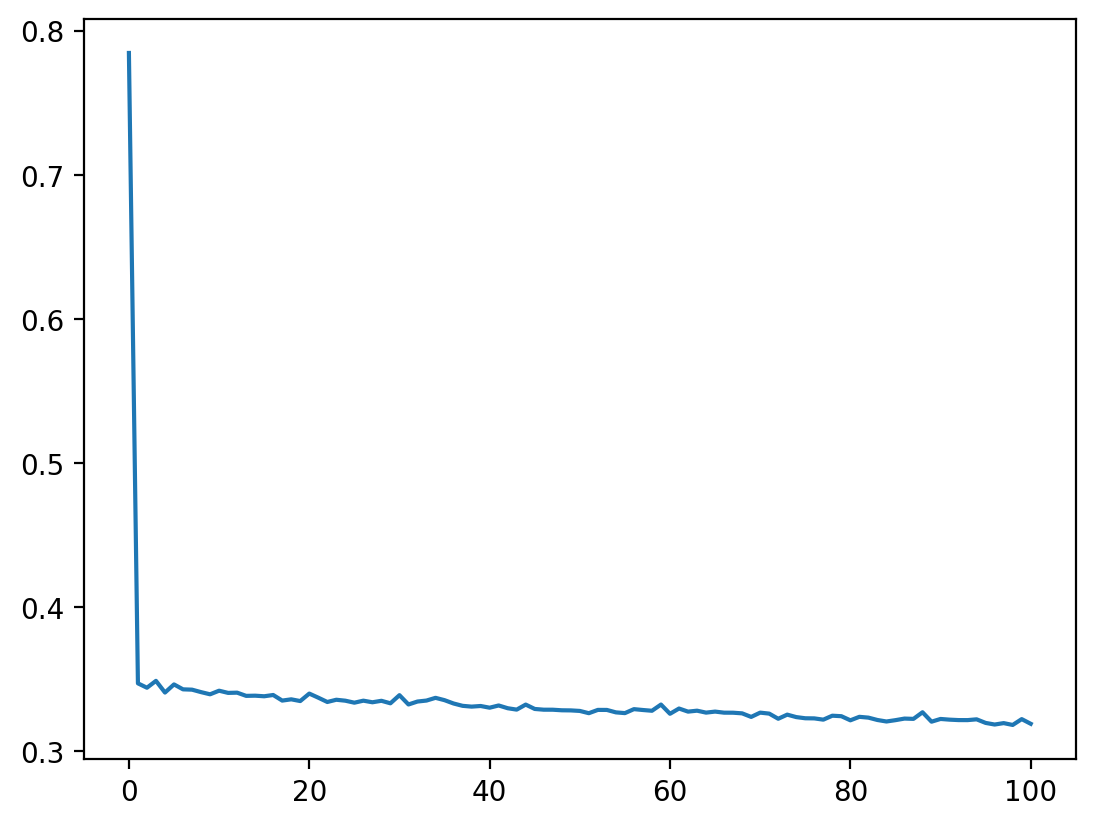

In [27]:
plt.plot(average_log_losses['val'])

In [30]:
init_idx = torch.zeros((1,1,2), dtype=torch.long, device=device)
generated_tokens = model.generate(init_idx, max_new_tokens=512).cpu()

ValueError: too many values to unpack (expected 2)

In [ ]:
generated_tokens[0, :24, :]

In [ ]:
generated_tokens.shape

In [ ]:
score = generated_tokens[0, :, 0]
vocab.to_tokens(score)

In [ ]:
generated_stream = idx_to_stream_enc(np.array(score), vocab)
generated_stream.plot()

In [ ]:
generated_stream.show('midi')